*In this notebook: 
1- Unsupervised clustering of images 
2- Spatial classifiers of images
3- Optimization *

# 1- Unsupervised clustering of images 


### To-do

- Write robustness function
- use eventually for now and try to generate one pattern
- fix the reshapes


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan  7 11:12:32 2021

@author: suhail
"""

# loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.models import Model
import pickle

# clustering, dimension reduction, feature selection
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import time
import timeit
import scipy
# learning classifiers
from mpl_toolkits.mplot3d import Axes3D



import regex
from scipy.io import savemat


In [2]:
## Load the dataset
path = r"F:\Projects\NIH_Organoid\Jup\images"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
images = []
# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'): #or file.name.endswith('.jpg'):
          # adds only the image files to the images list
            images.append(file.name)

### method 1: pretrained RNN  
Only model 1 is working fro now

In [3]:
## load the pre-trained CNN model

#Model 1: VGG16
from keras.applications.vgg16 import VGG16 
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
"""
#Model 2: inception
#loading the base model
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
# Model 3: ResNet50
from tensorflow.keras.applications import ResNet50
model = ResNet50()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
# Model 4: efficientnet
# !pip install -U efficientnet  # conda?

import efficientnet.keras as efn
model = efn.EfficientNetB0()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
"""

'\n#Model 2: inception\n#loading the base model\nfrom tensorflow.keras.applications.inception_v3 import InceptionV3\nmodel = InceptionV3()\nmodel = Model(inputs = model.inputs, outputs = model.layers[-2].output)\n# Model 3: ResNet50\nfrom tensorflow.keras.applications import ResNet50\nmodel = ResNet50()\nmodel = Model(inputs = model.inputs, outputs = model.layers[-2].output)\n# Model 4: efficientnet\n# !pip install -U efficientnet  # conda?\n\nimport efficientnet.keras as efn\nmodel = efn.EfficientNetB0()\nmodel = Model(inputs = model.inputs, outputs = model.layers[-2].output)\n'

In [4]:
## define functions for feature extraction and visualizing clusters
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
        # image_data_bw = img.max(axis=2)
        # non_empty_columns = np.where(image_data_bw.max(axis=0)>0)[0]
        # non_empty_rows = np.where(image_data_bw.max(axis=1)>0)[0]
        # cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
        # img_new = img[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1 , :]
        # new_image = img.fromarray(img_new)
        # new_image.save('%s.png',file)
        # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
        # img = np.mean(img, axis=2)
    reshaped_img = img.reshape(1,224,224,3) 
    
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features


def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        print(file)
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [ ]:
# Extracting features from images 
# uncomment the next two lines for ready-to-use sample
# comment the following

data = {}
p = r"dump"

# loop through each image in the dataset
start = timeit.default_timer()
for image in images:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(image,model)
        data[image] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
            
stop = timeit.default_timer()
print('Feature extraction time: ', stop - start)

# get a list of the filenames
filenames = np.array(list(data.keys()))
# get a list of just the features
feat = np.array(list(data.values()))
# reshape so that there are 210 samples of 4096 vectors

feat = feat.reshape(-1,4096)
# save the feature vector to avoid running everytime 
pkl_filename = "features.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(feat, file)
    
filenames = np.array(list(images))

pkl_filename = "images_names.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(filenames, file)

"""
df = pd.read_csv('image_labels.csv')
label = df['label'].tolist()
unique_labels = list(set(label))
"""

In [5]:
pkl_filename = "features.pkl"
feat = pickle.load(open(pkl_filename, 'rb'))
pkl_filename = "images_names.pkl"
filenames = pickle.load(open(pkl_filename, 'rb'))

## Clustering

In [6]:
# run this cell if you want to cluster using the reduced feature vector
pkl_filename = "selected_features.pkl"
ind_feat_red = pickle.load(open(pkl_filename, 'rb'))
X_clstr = feat[:,ind_feat_red]
X_clstr.shape

(21950, 20)

In [7]:
# cluster feature vectors into no_clusters
X_clstr =feat
no_clusters = 5

start = timeit.default_timer()
kmeans = KMeans(n_clusters=no_clusters, random_state=22) # change number of clusters here
kmeans.fit(X_clstr)
stop = timeit.default_timer()
print('Fitting time: ', stop - start)
# holds the cluster id and the images { id: [images] }
groups = {}
count = 0 
y=[]
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    y.append (cluster)
    count = count+1
    
y = np.array(y)
############## save
cwd = os.getcwd()
print(cwd)
pkl_filename ='patterns.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(groups, file)
savemat('patterns.mat',{"image_name":filenames,"image_label":kmeans.labels_})

Fitting time:  35.158421299999986
F:\Projects\NIH_Organoid\Jup\images


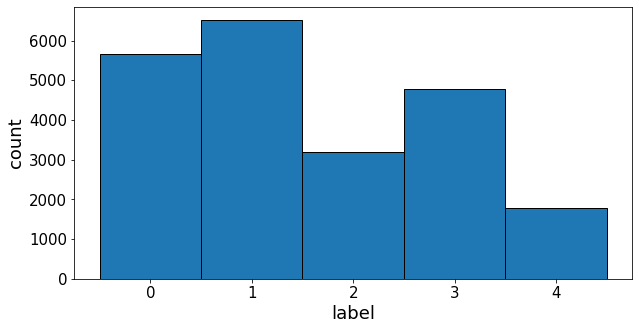

In [39]:

counts, bins = np.histogram(y)
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(y, np.arange(0,6)-1+0.5, ec="k")
plt.title('')
plt.xlabel('label', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )

plt.show()
ax.locator_params(axis='x', integer=True)



class number:  0
Clipping cluster size from 5656 to 30
1plot_12000.png
plot_13000.png
plot_13500.png
plot_14000.png
plot_14500.png
plot_15000.png
plot_15500.png
plot_16000.png
plot_12500.png
plot_12000.png
plot_11500.png
plot_11000.png
plot_10500.png
plot_13000 (2).png
plot_13000 (3).png
plot_13000 (4).png
plot_13000 (5).png
plot_13000 (6).png
plot_13500 (2).png
plot_13500 (3).png
plot_13500 (4).png
plot_13500 (5).png
plot_13500 (6).png
plot_14000 (2).png
plot_14000 (3).png
plot_14000 (4).png
plot_14000 (5).png
plot_14000 (6).png
plot_14500 (2).png
class number:  1
Clipping cluster size from 6520 to 30
plot_24000 (8).png
plot_24000.png
plot_16500.png
plot_17000.png
plot_17500.png
plot_18000.png
plot_18500.png
plot_19000.png
plot_19500.png
plot_20000.png
plot_20500.png
plot_21000.png
plot_21500.png
plot_22000.png
plot_22500.png
plot_23000.png
plot_23500.png
plot_24000 (2).png
plot_24000 (3).png
plot_24000 (4).png
plot_24000 (5).png
plot_24000 (6).png
plot_24000 (7).png
plot_24000 (9).pn

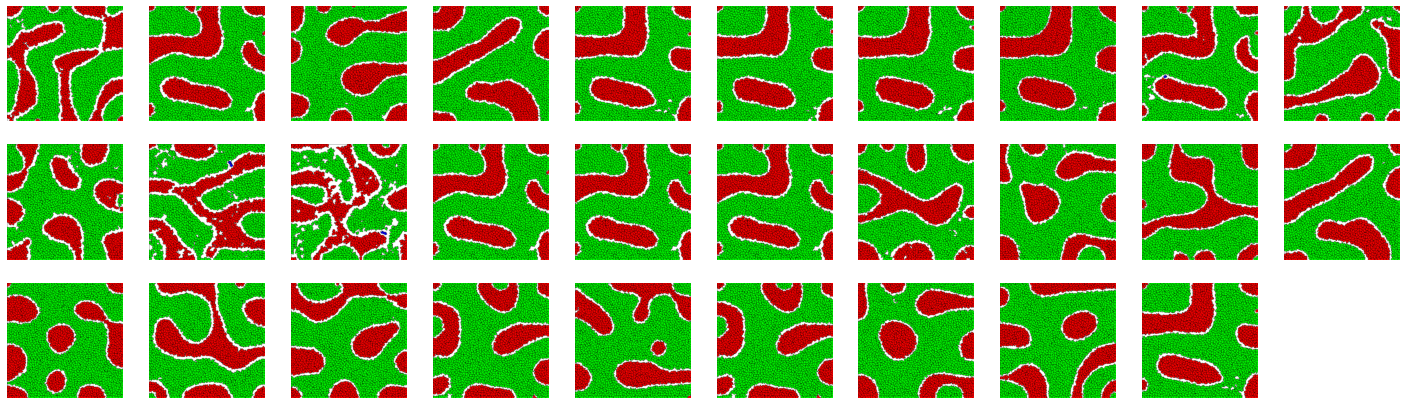

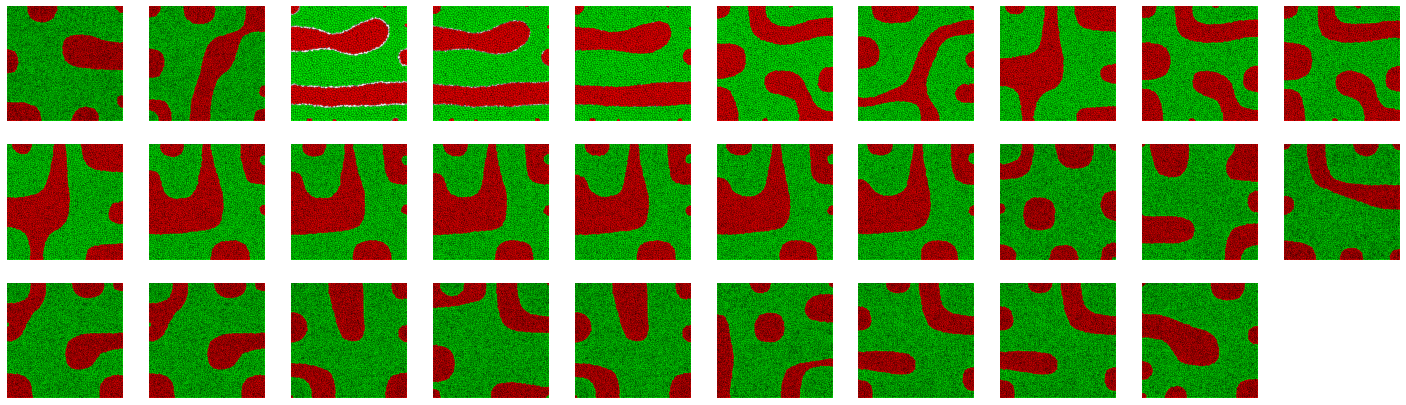

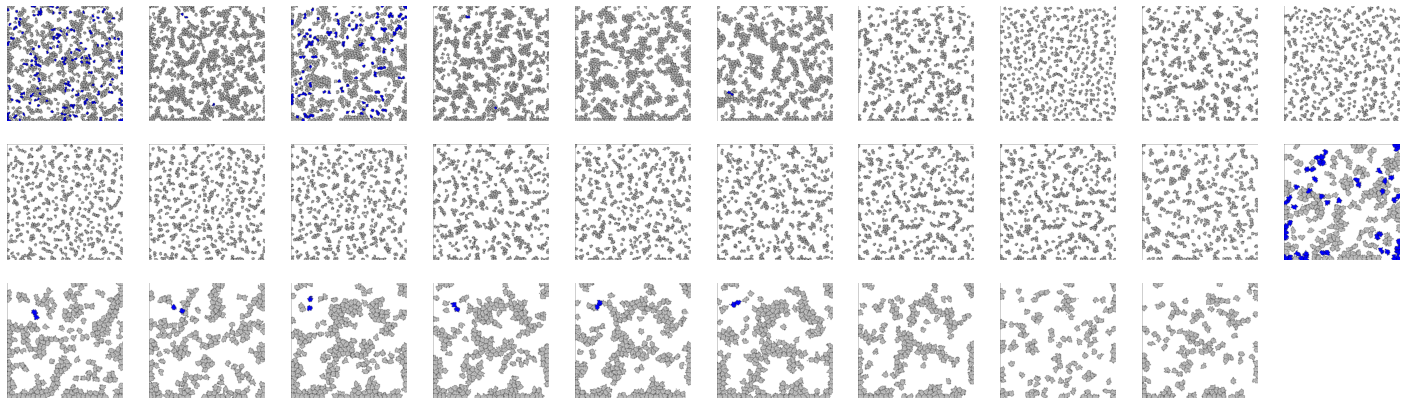

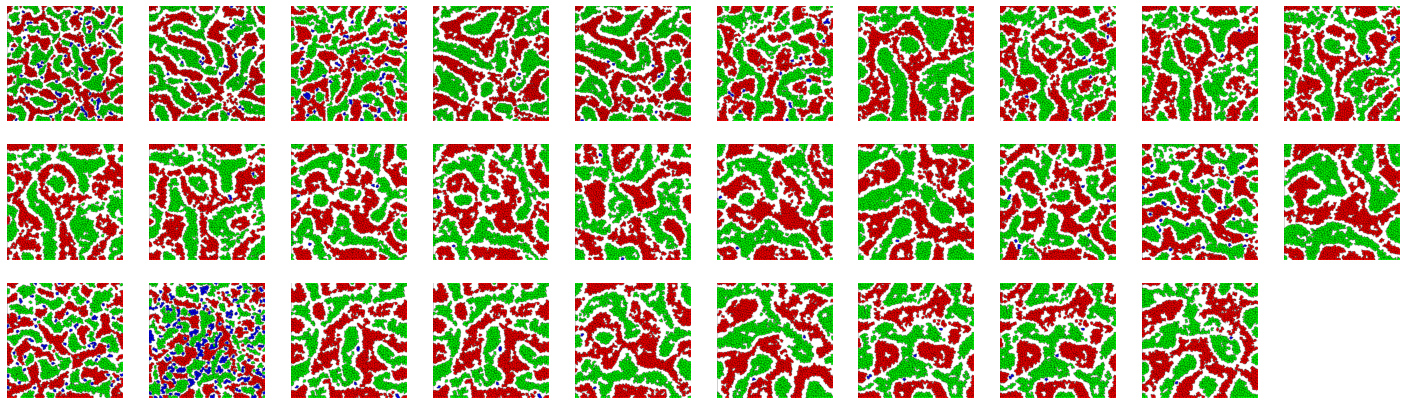

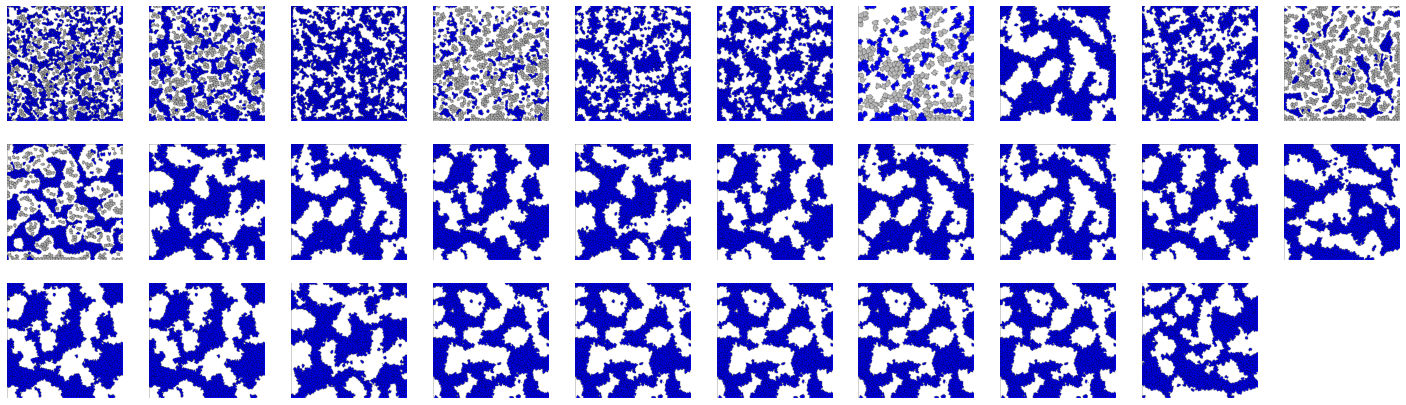

In [55]:
# view the resultant clusters 
for i in range(no_clusters):
    print('class number: ', i)
    view_cluster(i)

In [ ]:
## dimensionality reduction using PCA
no_components = 100
pca = PCA(n_components=no_components)
pca = pca.fit(feat)
x_pca = pca.transform(feat)
#print(pca.explained_variance_ratio_)
# Save pca to file in the current working directory
pkl_filename = "pca_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pca, file)

# LDA for visualization
no_components = 100
clr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
       '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
       '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] 
lda=LDA(n_components=3)
x_lda=lda.fit_transform(x_pca,y)
# Visualize the date in a lower dimension using LDA
x_min, x_max = x_pca[:, 0].min() - .5, x_pca[:, 0].max() + .5
y_min, y_max = x_pca[:, 1].min() - .5, x_pca[:, 1].max() + .5
#z_min, z_max = x_pca[:, 2].min() - .5, x_pca[:, 2].max() + .5

h = .5  # step size in the mesh
 # Generate a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
plot_labs =[]

# 3D plot PCA 

for i in range(no_clusters):
    pattern_name = 'class#' + str(i+1)
    plot_labs.append(pattern_name)
    
fig=plt.figure(figsize=(10,10),facecolor='w')

ax = fig.add_subplot(111, projection='3d')

label_index = np.zeros(no_clusters)
for i in range(len(x_lda)):
    if label_index[y[i]] == 0:
        label_index[y[i]] = 1
        ax.scatter(x_lda[i, 0], x_lda[i, 1],x_lda[i, 2],c=clr[y[i]],s=50.0,alpha=.3,label=plot_labs[y[i]])#,edgecolors='b')
    else:
        ax.scatter(x_lda[i, 0], x_lda[i, 1],x_lda[i, 2],c=clr[y[i]],s=50.0,alpha=.3)#,label=plot_labs[y[i]])#,edgecolors='b')

plt.legend()
plt.show()
save_path='3D.png'
plt.savefig(save_path)#, bbox_inches='tight')

###ax.plot3D(x_lda[:, 0], x_lda[:, 1], x_lda[:, 2])
####,  zdir='z'
fig=plt.figure(figsize=(15,15),facecolor='w')
label_index = np.zeros(no_clusters)

for i in range(len(x_lda)):
    if label_index[y[i]] == 0:
        label_index[y[i]] = 1
        plt.scatter(x_lda[i, 0], x_lda[i, 1],c=clr[y[i]],s=50.0,alpha=.3,label=plot_labs[y[i]])
    else:
        plt.scatter(x_lda[i, 0], x_lda[i, 1],c=clr[y[i]],s=50.0,alpha=.3)#,label=plot_labs[i])

fig.suptitle('SVC', fontsize=14, fontweight='bold')

plt.legend()
plt.show()
save_path='2D.png'
plt.savefig(save_path, bbox_inches='tight')
plt.close("all")



<b>Visualizations using t-distributed stochastic neighbor embedding (TSNE)</b>

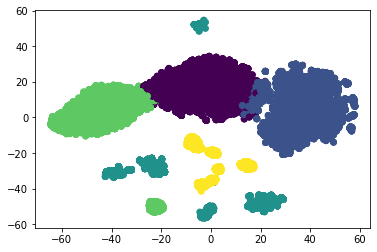

In [42]:
import sklearn.decomposition
import sklearn.manifold
import sklearn.linear_model
n = 100 #can adjust this to improve visualization
PCA_reduced = sklearn.decomposition.PCA(n_components=n).fit_transform(feat) #reduced dimensionality for TSNE

TSNE_embed = sklearn.manifold.TSNE(n_components=2, perplexity=300).fit_transform(PCA_reduced) #adjusting perplexity also can improve the visualization
plt.scatter(TSNE_embed[:,0], TSNE_embed[:,1], c=y)

## Feature selection

In [43]:
# #############################################################################
# prepare data for feature selection
X =feat #n_samples * n_genes
y = y #age group
np.random.seed(0)
X = np.hstack((X, 2 * np.random.random((X.shape[0], 36))))

# #############################################################################
# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have an full-blown estimator
clf = Pipeline([('anova', SelectPercentile(chi2)),
                ('scaler', StandardScaler()),
                ('svc', SVC(gamma="auto"))])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

# for percentile in percentiles:
#     clf.set_params(anova__percentile=percentile)
#     this_scores = cross_val_score(clf, X, y)
#     score_means.append(this_scores.mean())
#     score_stds.append(this_scores.std())

# plt.errorbar(percentiles, score_means, np.array(score_stds))
# plt.title(
#     'Performance of the SVM-Anova varying the percentile of features selected')
# plt.xticks(np.linspace(0, 100, 11, endpoint=True))
# plt.xlabel('Percentile')
# plt.ylabel('Accuracy Score')
# plt.axis('tight')

# plt.show()


In [44]:
start = timeit.default_timer()
            
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

log_reg2 = sklearn.linear_model.LogisticRegressionCV(cv=5, Cs=[0.01, 0.1, 1, 10],
                                                    max_iter=5000,
                                                    penalty='l2', solver='liblinear',
                                                    multi_class='ovo')

log_reg2.fit(X_train,y_train) #this needs to be on a subset of new data for correct scores, here we use the test data

log_reg2_training_validation_score = log_reg2.score(X_train,y_train) #getting the cross validation score

print('Training validation score')
print(log_reg2_training_validation_score)

log_reg2_training_validation_score = log_reg2.score(X_test, y_test) #getting the cross validation score

print('Testing validation score')
print(log_reg2_training_validation_score)
stop = timeit.default_timer()


Training validation score
1.0
Testing validation score
0.9969630038652678


In [ ]:
# select features based on best logistic regression coefficient
CV_coefficients = log_reg.coef_ #finding coefficients of the logistic regression equation (there will be a column of coeff for each feature fot each class, so a 5x4096 matrix)
Sum_coef = np.sum(np.abs(CV_coefficients), axis=0) #summing the coeff by class to get 1x4096 
Num_features = 20 #can change this to increase accuracy 
ind_feat_red = Sum_coef.argsort()[-Num_features:] #select n features with largest overall coefficients 

cwd = os.getcwd()
print(cwd)
pkl_filename = "selected_features.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(ind_feat_red, file)

In [ ]:
# test the selected features by training a new logistic regression model
X_red = test_features[:,ind_feat_red]
y = test_labels

X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.33, random_state=42)

log_reg2 = sklearn.linear_model.LogisticRegressionCV(cv=5, Cs=[0.01, 0.1, 1, 10],
                                                    max_iter=5000,
                                                    penalty='l2', solver='liblinear',
                                                    multi_class='ovr')

log_reg2.fit(X_train,y_train) #this needs to be on a subset of new data for correct scores, here we use the test data

log_reg2_training_validation_score = log_reg2.score(X_train,y_train) #getting the cross validation score

print('Training validation score')
print(log_reg2_training_validation_score)

log_reg2_training_validation_score = log_reg2.score(X_test, y_test) #getting the cross validation score

print('Testing validation score')
print(log_reg2_training_validation_score)

# 2- Spatial Classifiers
## approach 1: SVM
## approach 2: TSSL


## 2.1 - SVM

In [54]:
# use the reduced feature vector 
X_red = X[:,ind_feat_red]
y = y

# split data for training and testing

X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.33,random_state=10)
print (X_train.shape , X_test.shape)
n_samples, n_features = X_train.shape
print('number of samples and features')
print(n_samples, n_features)
# learn SVM Classifiers
### C - SVM regularization parameter 
start = timeit.default_timer()
classifier= svm.SVC(kernel='linear', C=0.1, probability=True,decision_function_shape='ovo', verbose= True).fit(X_train, y_train)
stop = timeit.default_timer()
print('Training time: ', stop - start)
print('Training classification score:')
print (classifier.score(X_train, y_train))
print('Testing classification score:')
print (classifier.score(X_test, y_test))

# Save to file in the current working directory
pkl_filename = "spatial_classifiers_ovr_red.pkl" #change the name if needed
with open(pkl_filename, 'wb') as file:
    pickle.dump(classifier, file)

coef=classifier.coef_
intercept=classifier.intercept_
OutInCoef=coef[6]
OutInIntercept= intercept[6]
print (OutInCoef, '\n' ,  OutInIntercept)

(14706, 20) (7244, 20)
number of samples and features
14706 20
[LibSVM]Training time:  1.1086552000001575
Training classification score:
0.9952400380796954
Testing classification score:
0.9937879624516841
[ 0.02141349 -0.07083826  0.00441184 -0.00403178  0.00538609  0.09072437
  0.0170713   0.00371713  0.06140244  0.00752819  0.10643158  0.004082
  0.          0.0673264  -0.07119543  0.00419097 -0.01812012  0.08813573
  0.10510832 -0.08186886] 
 -1.9224503405232956


<b>Test on new images

In [ ]:
## upload existing classifier?
pkl_filename = "spatial_classifiers_ovr_red.pkl"
classifier = pickle.load(open(pkl_filename, 'rb'))
    
# test the classifier with new images
path = r"F:\Projects\NIH_Organoid\Jup\images_test"
os.chdir(path)

# this list holds all the image filename
images_test = []
#upload images
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the images list
            images_test.append(file.name)
data_test = {}
p = r"dump"

# extract features
for image in images_test:
    # try to extract the features and update the dictionary
    try:
        x_test = extract_features(image,model)
        data_test[image] = x_test
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(x_test,file)
            
# get a list of the filenames
filenames_test = np.array(list(data_test.keys()))
# get a list of just the features
x_test = np.array(list(data_test.values()))
# reshape so that there are 210 samples of 4096 vectors
x_test = x_test.reshape(-1,4096)


# use only the selected features 



for image_ind in data_test:
    x_test = data_test[image_ind]
    x_test_red =x_test[:,ind_feat_red]
    ccc = classifier.predict(x_test_red.reshape(1,-1))
    print('class number predicted:',ccc)
    dist_ = classifier.decision_function(x_test_red.reshape(1,-1))
    print('Predict confidence scores:',dist_)
#     dist = np.zeros((10, 10))
#     dist[np.tril_indices(10,-1)] = dist_  
#     print('Predict confidence scores:',dist)
    # The confidence score for a sample is proportional to the signed distance of that sample to the hyperplane.
    plt.imshow(dist_)
    plt.grid(True)
    plt.show()
    
    print(image_ind)
    img = load_img(image_ind)
    img = np.array(img)
    plt.imshow(img)
    plt.show()
    path = r"F:\Projects\NIH_Organoid\Jup\images"
    # change the working directory to the path where the images are located
    os.chdir(path)
    view_cluster(ccc[0])
    path = r"F:\Projects\NIH_Organoid\Jup\images_test"
    # change the working directory to the path where the images are located
    os.chdir(path)
    


In [ ]:
model

In [ ]:
dist

In [ ]:
images_test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs


# we create 40 separable points
X, y_ = make_blobs(n_samples=40, centers=2, random_state=6)

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y_, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
          linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [ ]:
clf.decision_function(xy).shape

## 2.2 - TSSL

# 3-  spatio-temporal classifiers (Erfan)

# 4- Optimization 


In [ ]:
#### import packages 

# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import time

#  
from mpl_toolkits.mplot3d import Axes3D



# other packages 
import  os
import numpy as np
import datetime
import multiprocessing
from sys import stdout

#initial parameters

path="/add/path/"

In [ ]:
# robustness function

def robustness(x):
    #hyperparameters and initializations
    n_components = 20
    similarity_score =[]
    # STL formula
    stl_times   = np.array([0, 200])
    stl_classes = np.array([7, 1])
    
    #Now make a new simulation
    p1=x[0]
    p2=x[1]
    p3=x[2]
    p4=x[3]
    p5 = x[4]
    
    sim_id = "%s_%s_%s_%s_%s" % (np.int(p1),np.int(p2),np.int(p3),np.int(p4),np.int(p5))
    while os.path.exists("/home/robotics/Documents/Suhail/Jup/simulations/%s" %sim_id):
        sim_id = sim_id+1
        print(sim_id)
        
    
    num_mesendo = 100
    simulation_time =50
    # run the simulaion using parameter vector x
    run_file = 'python3 /home/robotics/Documents/Suhail/Jup/MorpheusSetup.py \" %s " " %s " " %s " " %s " " %s " " %s " " %s " " %s "' % (
                 str(p1),str(p2),str(p3),str(p4),
                 str(p5),str(num_mesendo),str(sim_id),str(simulation_time))
    os.chdir(r"/home/robotics/Documents/Suhail/Jup/")
    os.system(run_file)
    
    # extract features from simulation images and reduce dimensionality
    feat_reduced = pca_reduce(sim_id)
    
    # Load spatial classifiers from file
    pkl_filename = "/home/robotics/Documents/Suhail/Jup/images_test/spatial_classifiers.pkl"
    with open(pkl_filename, 'rb') as file:
        classifier = pickle.load(file)
    similarity_score =[]
    for j in range(feat_reduced.shape[0]):
        check = classifier.predict(feat_reduced[j].reshape(1,-1)) - stl_classes[j]
        similarity = abs(check)
        if similarity == 0: 
            similarity = 1 
        else:
            similarity = -1
            
        similarity_score.append(similarity) 
    robustness_score = max(similarity_score)   
    
    return robustness_score


# function to extract features from images 
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    feat = model.predict(imgx, use_multiprocessing=True)

    return feat

# reduce dimensionality

def pca_reduce(sim_id):
    path = r"/home/robotics/Documents/Suhail/Jup/simulations/ %s " %sim_id
    # change the working directory to the path where the images are located
    os.chdir(path)
    
    # this list holds all the image filename
    images = []
    # creates a ScandirIterator aliased as files
    with os.scandir(path) as files:
      # loops through each file in the directory
        for file in files:
            if file.name.endswith('.png'):
              # adds only the image files to the images list
                images.append(file.name)
                
    model = VGG16()
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    data = {}
    p = r"/home/robotics/Documents/Suhail/Jup/dump.pkl"
    
    # lop through each image in the dataset
    for image in images:
        # try to extract the features and update the dictionary
        try:
            feat = extract_features(image,model)
            data[image] = feat
        # if something fails, save the extracted features as a pickle file (optional)
        except:
            with open(p,'wb') as file:
                pickle.dump(data,file)
     
    # get a list of the filenames
    filenames = np.array(list(data.keys()))
    
    # get a list of just the features
    feat = np.array(list(data.values()))
    
    # reshape so that there are 210 samples of 4096 vectors
    feat = feat.reshape(-1,4096)
    # Load pca    
    """
    pkl_filename = "pca_model.pkl"
    with open(pkl_filename, 'rb') as file:
        pca = pickle.load(file)
    # reduce the amount of dimensions in the feature vector
    x_pca = pca.fit_transform(feat)
    print(pca.explained_variance_ratio_)
    feat_reduced=x_pca
    """
    feat_reduced = feat
    stdout.flush()
    return feat_reduced



In [ ]:
######################### main ############# 

simulation_time = 200
step_size = 10
p1 = np.arange(start=0, stop=500, step=step_size) # pp_chemo_strength
p2 = np.arange(start=-500, stop=0, step=step_size) # mn_chemo_strength
p3 = np.arange(start=-500, stop=0, step=step_size) # me_chemo_strength
p4 = np.arange(start=-500, stop=0, step=step_size) # en_chemo_strength
p5 = np.arange(start=0, stop=1, step=1) # random_seed

#bounds for input parameters
lb=[min(p1),min(p2),min(p3),min(p4),min(p5)]
ub=[max(p1),max(p2),max(p3),max(p4),max(p5)]

lb = np.array(lb)
ub = np.array(ub)

#PSO hyperparameters
vhigh = np.abs(ub - lb)
vlow = -vhigh
particle_output=1
debug=1
no_particles=1
no_cores=16
omega=0.3925 #-0.3328
phip=2.5586
phig=1.3358  #2.8446
maxiter=50

In [ ]:

# Initialize the particle swarm
S =no_particles
D = len(lb)  # the number of dimensions each particle has
x = np.random.rand(S, D)  # particle positions
v = np.zeros_like(x)  # particle velocities
p = np.zeros_like(x)  # best particle positions
fx = np.zeros(S)  # current particle function values
fp = np.ones(S)*np.inf  # best particle function values
fp=fp.reshape(1,-1)
g = []  # best swarm position
fg = np.inf  # best swarm position starting value

# Initialize the particle's position
x = lb + x*(ub - lb)
# Calculate objective for each particle
#obj=robustness


In [ ]:
mp_pool = multiprocessing.Pool(no_cores )
fx = np.array(mp_pool.map(robustness, x))
fx=fx.reshape(1,-1)
print ("finish first pool")
stdout.flush()

In [ ]:
i_update.shape[0]

In [ ]:
# Store particle's best position
i_update = np.logical_and((fx < fp), True)
dim =i_update.shape[0]
i_update = i_update.reshape((dim,))
p[i_update, :] = x[i_update, :].copy()
i_update=i_update.reshape(1,-1)
fp[i_update] = fx[i_update]
# Update swarm's best position
i_min = np.argmin(fp)
fp =fp.reshape((dim,))
if fp[i_min] < fg:
    fg = fp[i_min]
    g = p[i_min, :].copy()
else:
# At the start, there may not be any feasible starting point, so just
# give it a temporary "best" point since it's likely to change
    g = x[0, :].copy()

# Initialize the particle's velocity
v = vlow + np.random.rand(S, D)*(vhigh - vlow)

#Delete all directories
#shutil.rmtree(path)
#os.makedirs(path)

In [ ]:
#Iterate until termination criterion met #####
it = 1
while it <= maxiter:
    rp = np.random.uniform(size=(S, D))
    rg = np.random.uniform(size=(S, D))
# Update the particles velocities
    v = omega*v + phip*rp*(p - x) + phig*rg*(g - x)
        # Update the particles' positions
    x = x + v
        # Correct for bound violations
    maskl = x < lb
    masku = x > ub
    x = x*(~np.logical_or(maskl, masku)) + lb*maskl + ub*masku

# Update objectives and constraints
    fx = np.array(mp_pool.map(robustness, x))
    print ("finish pool at it %d"%(it))
    stdout.flush()


    # Store particle's best position (if constraints are satisfied)
    fp=fp.reshape(-1,1)
    i_update = np.logical_and((fx < fp), True)
    dim =i_update.shape[0]
    i_update = i_update.reshape((dim,))
    p[i_update, :] = x[i_update, :].copy()
    i_update=i_update.reshape(1,-1)
    fp[i_update] = fx[i_update]

# Compare swarm's best position with global best position
    i_min = np.argmin(fp)
    fp =fp.reshape((dim,))
    if fp[i_min] < fg:
        if debug:
            print('New best for swarm at iteration {:}: {:} {:}'\
                  .format(it, p[i_min, :], fp[i_min]))

        p_min = p[i_min, :].copy()
        stepsize = np.sqrt(np.sum((g - p_min)**2))
        g = p_min.copy()
        fg = fp[i_min]
    if debug:
        print('Best after iteration {:}:\n parameters = {:} \robustness {:}'.format(it, g, fg))
        stdout.flush()
    it += 1
    #shutil.rmtree(path)
    #os.makedirs(path)
print('Stopping search: maximum iterations reached --> {:}'.format(maxiter))
stdout.flush()
if particle_output:
    print (g, fg, p, fp)
    stdout.flush() 

# Additional steps 


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 


In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
train_dir= r"/home/robotics/Documents/Suhail/Jup/images_opt"
validation_dir= r"/home/robotics/Documents/Suhail/Jup/images_test"
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))